<div style="text-align: center;">

<!-- Logo de la faculté -->
<img src="doc/fac-sciences-eco_logo2.png" alt="Logo de la Faculté" width="300">

<h1 style="margin-bottom: 0;">Étude de l’impact du VIX sur les marchés boursiers mondiaux</h1>
<h2 style="margin-top: 5px; margin-bottom: 20px;">Advanced Econometrics</h2>

<p><strong>Étudiants :</strong><br>
BOULMEDAIS Sam<br>
PHALIER Noé</p>

<p><strong>Professeur :</strong><br>
RONDEAU Fabien</p>

<p><strong>Date :</strong> Novembre 2025</p>

</div>

---

## Introduction

La volatilité occupe une place centrale dans l’analyse des marchés financiers. Elle traduit le degré d’incertitude et d’instabilité perçu par les investisseurs. Elle constitue souvent un signal clé des mouvements à venir sur les marchés mondiaux.  

Dans ce contexte, ce projet a pour objectif d’étudier l’influence de la volatilité du marché financier américain, mesurée par l’indice **VIX**, sur la performance du marché boursier européen, représentée par l’indice **EuroStoxx 50**.  

**Le VIX : un baromètre de l’incertitude mondiale**.  

Le **VIX** (*Volatility Index*), élaboré par le **Chicago Board Options Exchange (CBOE)**, mesure la volatilité implicite des options sur le **S&P 500**. Souvent surnommé « *indice de la peur* », le VIX reflète les anticipations des investisseurs concernant les fluctuations du marché à court terme :  
- Une **hausse du VIX** traduit une montée de l’aversion au risque et une augmentation de l’incertitude.  
- Une **baisse du VIX** signale, au contraire, un climat de confiance et une stabilité perçue.  

**L’EuroStoxx 50 : reflet du marché européen**.  

L’**EuroStoxx 50** regroupe les **50 plus grandes capitalisations boursières** de la zone euro. Il constitue un **indice de référence** pour évaluer la performance des marchés actions européens et pour suivre la conjoncture économique de la région.  

## Objectif et méthodologie  

Ce travail vise à **analyser la manière dont les variations du VIX influencent la dynamique du marché européen**, en mettant en évidence la **transmission de la volatilité américaine vers l’Europe**.  

Pour enrichir l’analyse, plusieurs **variables macroéconomiques européennes** sont intégrées :  
- le **taux de chômage** de la zone Euro,  
- le **taux directeur** de la BCE,  
- la **production industrielle** de la zone Euro,  
- et le **taux de change EUR/USD**.  

La méthodologie repose sur l’estimation d’un **modèle SVAR (Structural Vector AutoRegression)**, permettant d’examiner les interrelations entre ces variables et d’identifier les effets structurels de la volatilité sur la performance boursière.  

*Problématique : Dans quelle mesure la volatilité des marchés financiers américains, telle que mesurée par le VIX, influence-t-elle la dynamique du marché boursier européen représenté par l’EuroStoxx 50, et comment cette transmission de volatilité interagit-elle avec les principales variables macroéconomiques de la zone euro ?*.  

---

## 1. Importation des packages

In [ ]:
# Exécuter cette commande dans le terminal avant de lancer le notebook

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import taceconomics
taceconomics.api_key = 'sk_o24BhJRqVpIvxVSXX3yiKRGgpDEejmyJ8pfLFX2q22s' #clé API à remplacer par la vôtre

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings('ignore')

---

## 2. Les données

### 2.1 Importation des données

In [85]:
# date de début des données
start_date = '2007-04-01'

# yfinance
tickers = {
    'VIX': '^VIX',
    'EuroStoxx50': '^STOXX50E',
    'EURUSD': 'EURUSD=X'
}

dic = {}

for name, ticker in tickers.items():
    data = yf.download(ticker, start=start_date, interval='1mo')
    dic[name] = data['Close']

# taceconomics
tac_tickers = {
    'IPI': f'ECB/STS_M_Y_PROD_NS0010_4_000/EUZ20?start_date={start_date}',
    'i_rate_EUR': f"ECB/FM_D_EUR_4F_KR_DFR_LEV/EUZ?collapse=M&collapse_mode=end_of_period&start_date={start_date}",
    'u_rate_EUR': f'EUROSTAT/EI_LMHR_M_LM-UN-T-TOT_SA_PC_ACT/EUZ20?start_date={start_date}'
}

for name, ticker in tac_tickers.items():
    data = taceconomics.getdata(ticker)
    data.index = pd.to_datetime(data.index)
    data.columns = [name]
    dic[name] = data

# DataFrame final
data = pd.concat(dic, axis=1).dropna()
data.columns = data.columns.droplevel(1)

data.head() 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,VIX,EuroStoxx50,EURUSD,IPI,i_rate_EUR,u_rate_EUR
2007-04-01,14.220000,4392.339844,1.365206,108.7,2.75,7.7
2007-05-01,13.050000,4512.649902,1.345605,110.4,2.75,7.7
2007-06-01,16.230000,4489.770020,1.353601,110.5,3.00,7.6
2007-07-01,23.520000,4315.689941,1.367204,110.4,3.00,7.6
2007-08-01,23.379999,4294.560059,1.364201,111.0,3.00,7.6


### 2.2 Analyse graphique

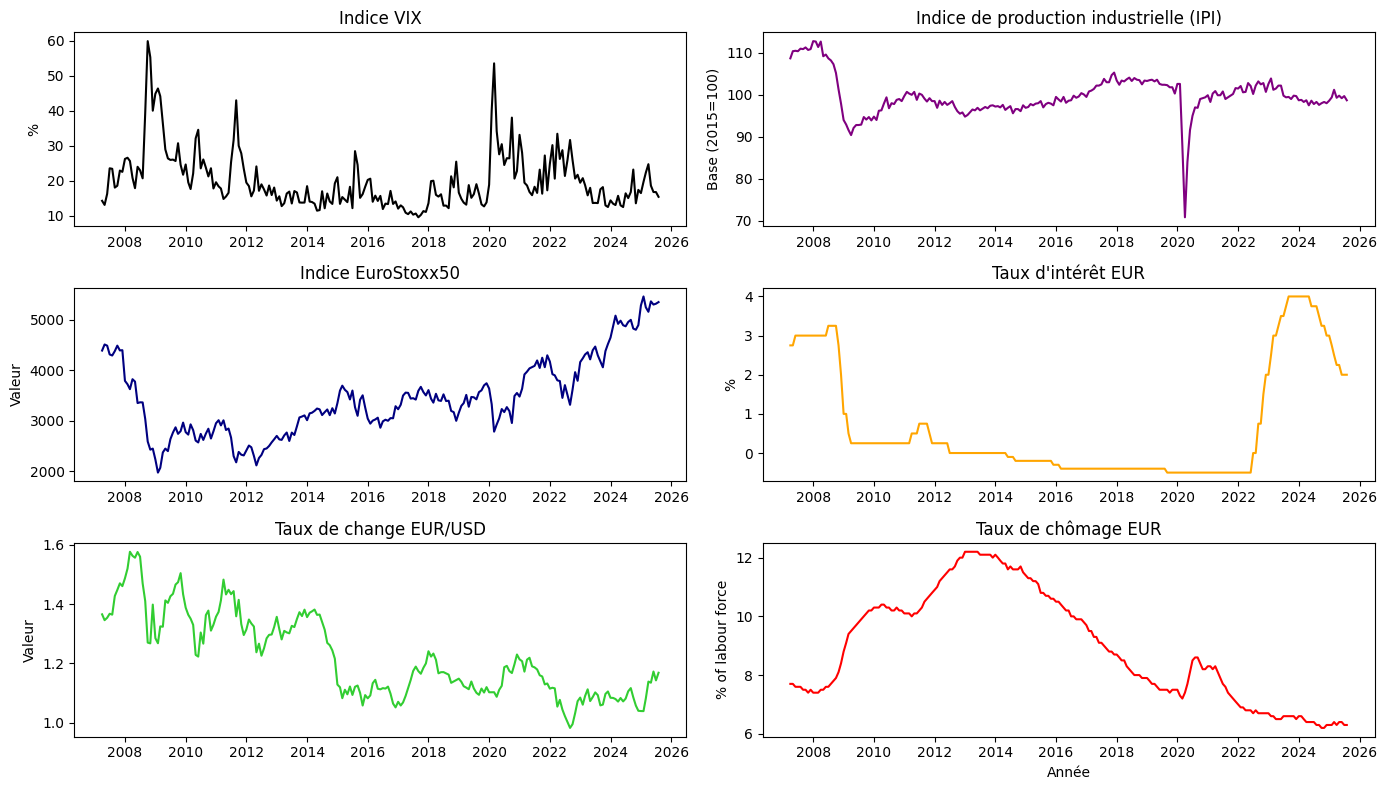

In [97]:
fig, axs = plt.subplots(3,2, figsize=(14, 8))

axs[0][0].plot(data['VIX'], color='black')
axs[0][0].set_title('Indice VIX')
axs[0][0].set_ylabel('%')

axs[1][0].plot(data['EuroStoxx50'], color='navy')
axs[1][0].set_title('Indice EuroStoxx50')
axs[1][0].set_ylabel('Valeur')

axs[2][0].plot(data['EURUSD'], color='limegreen')
axs[2][0].set_title('Taux de change EUR/USD')
axs[2][0].set_ylabel('Valeur')

axs[0][1].plot(data['IPI'], color='purple')
axs[0][1].set_title('Indice de production industrielle (IPI)')
axs[0][1].set_ylabel('Base (2015=100)')  

axs[1][1].plot(data['i_rate_EUR'], color='orange')
axs[1][1].set_title("Taux d'intérêt EUR")
axs[1][1].set_ylabel('%')

axs[2][1].plot(data['u_rate_EUR'], color='red')
axs[2][1].set_title('Taux de chômage EUR')
axs[2][1].set_ylabel('% of labour force')
axs[2][1].set_xlabel('Année')


plt.tight_layout()
plt.show()

#### Analyse de l’évolution du VIX et de l’EuroStoxx 50 (2007–2025)

Les graphiques présentent l’évolution conjointe du **VIX**, de l’**EuroStoxx 50** et de plusieurs variables macroéconomiques européennes entre 2007 et 2025.

**Tendances générales**

- Le **VIX**, indicateur de la volatilité implicite sur le marché américain, montre des **pics marqués en 2008–2009** (crise financière mondiale) et en **2020** (crise du COVID-19), reflétant une forte incertitude sur les marchés.  
- L’**EuroStoxx 50** réagit systématiquement à ces tensions, avec des baisses importantes lors des pics de volatilité.  
- Le **taux de change EUR/USD** se déprécie progressivement, illustrant la divergence des politiques monétaires entre la BCE et la Fed.

**Corrélation entre VIX et EuroStoxx 50**

L’analyse des courbes du VIX et de l’EuroStoxx 50 met en évidence une **corrélation inverse marquée** :  

- Les périodes de forte hausse du VIX coïncident avec des **baisses significatives** de l’EuroStoxx 50.  
- À l’inverse, lorsque le VIX diminue, le marché boursier européen tend à se **redresser**.

**Épisodes majeurs**

- **2008–2009 :** Crise financière mondiale → explosion du VIX et chute brutale de l’EuroStoxx 50.  
- **2011 :** Nouvelle hausse de la volatilité et recul des marchés européens.  
- **2020 :** Pandémie de COVID-19 → pic historique du VIX et effondrement temporaire de l’EuroStoxx 50.  
- **2022–2024 :** Tensions géopolitiques et remontée de l’inflation → nouveaux accès de volatilité, suivis d’une reprise nette à partir de 2024.

**Interprétation**

Cette relation négative illustre le rôle du **VIX comme baromètre de la confiance des investisseurs** :

- Une **hausse du VIX** traduit une montée de la peur et entraîne une baisse des prix des actions, y compris en Europe.  
- Une **baisse du VIX** indique un retour de la stabilité et favorise la reprise des marchés.

**Conclusion**

Sur la période 2007–2025, la dynamique du VIX permet d’expliquer **une grande partie des fluctuations de l’EuroStoxx 50**. On cherche donc à prouver que l’indice américain de volatilité constitue un **indicateur avancé pertinent** pour anticiper les phases de tension ou de reprise sur les marchés financiers européens.  

---

## 3. Stationnarité

### 3.1 Les tests

Pour tester la stationnarité des séries nous réalisé deux tests : ADF et KPSS

**Test ADF** (Augmented Dickey-Fuller)
- **H0 (hypothèse nulle)** : La série **possède une racine unitaire** → **non stationnaire**  
- **H1 (hypothèse alternative)** : La série **n’a pas de racine unitaire** → **stationnaire**  

Interprétation :  
- p-value < 0.05 → rejette H0 → série **stationnaire**  
- p-value ≥ 0.05 → ne rejette pas H0 → série **non stationnaire**  

**Test KPSS**
- **H0 (hypothèse nulle)** : La série **est stationnaire**  
- **H1 (hypothèse alternative)** : La série **n’est pas stationnaire**  

Interprétation :  
- p-value < 0.05 → rejette H0 → série **non stationnaire**  
- p-value ≥ 0.05 → ne rejette pas H0 → série **stationnaire**

### 3.2 Tests de stationnarité sur les séries brutes

In [ ]:
def test_adf(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Valeurs critiques :")
    for key, value in result[4].items():
        print(f"  {key}: {value}")
    print("\n")

def kpss_test(series):
    result = kpss(series, regression='c')
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Valeurs critiques :")
    for key, value in result[3].items():
        print(f"  {key}: {value}")
    print("\n")

# on teste la stationnarité des séries originales sur les valeurs 'Close'
for name in data.columns:
    print(f"----- {name} -----")
    test_adf(data[name])
    kpss_test(data[name])

**Résultats**

| Série           | Test ADF (p-value)       | Test KPSS (p-value)   | Stationnaire ?       | Transformation suggérée       |
|-----------------|-------------------------|----------------------|--------------------|-------------------------------|
| **VIX**             | 6.41e-06                | 0.0901               | Oui                | Aucune                        |
| **EuroStoxx50**     | 0.8907                  | 0.01                 | Non                | log-Δ           |
| **EURUSD**          | 0.3308                  | 0.01                 | Non                | log-Δ |
| **IPI**             | 0.0067                  | 0.1                  | Oui                | Aucune                        |
| **i_rate_EUR**      | 0.2381                  | 0.0690               | Probablement Non   | 1ère différence (Δ)           |
| **u_rate_EUR**      | 0.5890                  | 0.01                 | Non                | 1ère différence (Δ)           |

### 3.3 Stationnarisation

* Pour le VIX et l'IPI, on ne fait rien car elles sont déjà stationnaires.
* Pour l'EuroStoxx50 et le taux de change EURUSD, on utilise les rendements logarithmiques.
* Pour les variables macroéconomiques du taux d'intérêt et du taux de chômage, on utilise la première différence.

In [74]:
log_returns = np.log(data[["EuroStoxx50","EURUSD"]]).diff()
log_returns.columns = [f"log_return_{col}" for col in log_returns.columns]

diff = data[["i_rate_EUR","u_rate_EUR"]].diff()
diff.columns = [f"diff_{col}" for col in diff.columns]

# création du DataFrame final avec les transformations et suppression des NA
df_final = pd.concat([log_returns, diff, data[["VIX","IPI"]]], axis=1).dropna()
df_final.head()


,log_return_EuroStoxx50,log_return_EURUSD,diff_i_rate_EUR,diff_u_rate_EUR,VIX,IPI
2007-04-01,0.049305,0.021702,0.00,-0.1,14.220000,108.7
2007-05-01,0.027022,-0.014462,0.00,0.0,13.050000,110.4
2007-06-01,-0.005083,0.005925,0.25,-0.1,16.230000,110.5
2007-07-01,-0.039544,0.009999,0.00,0.0,23.520000,110.4
2007-08-01,-0.004908,-0.002199,0.00,0.0,23.379999,111.0


### 3.4 Tests de stationnarité sur les séries transformées

In [ ]:
cols_to_test = ["log_return_EuroStoxx50", "log_return_EURUSD", "diff_i_rate_EUR", "diff_u_rate_EUR"]

for name in cols_to_test:
    print(f"----- {name} -----")
    test_adf(df_final[name])
    kpss_test(df_final[name])

**Résultats**

| Série           | Test ADF (p-value)       | Test KPSS (p-value)   | Stationnaire ?       |
|-----------------|-------------------------|----------------------|--------------------|
| **log_return_EuroStoxx50**     | 4.569e-13               | 0.1                 | Oui                | 
| **log_return_EURUSD**          | 8.888e-28               | 0.1                 | Oui                | 
| **diff_i_rate_EUR**      | 4.935e-05               | 0.1                 | Oui                | 
| **diff_u_rate_EUR**      | 0.0525                  | 0.0269              | ?                | 

### 3.5 Visualisation graphique des séries stationnaires

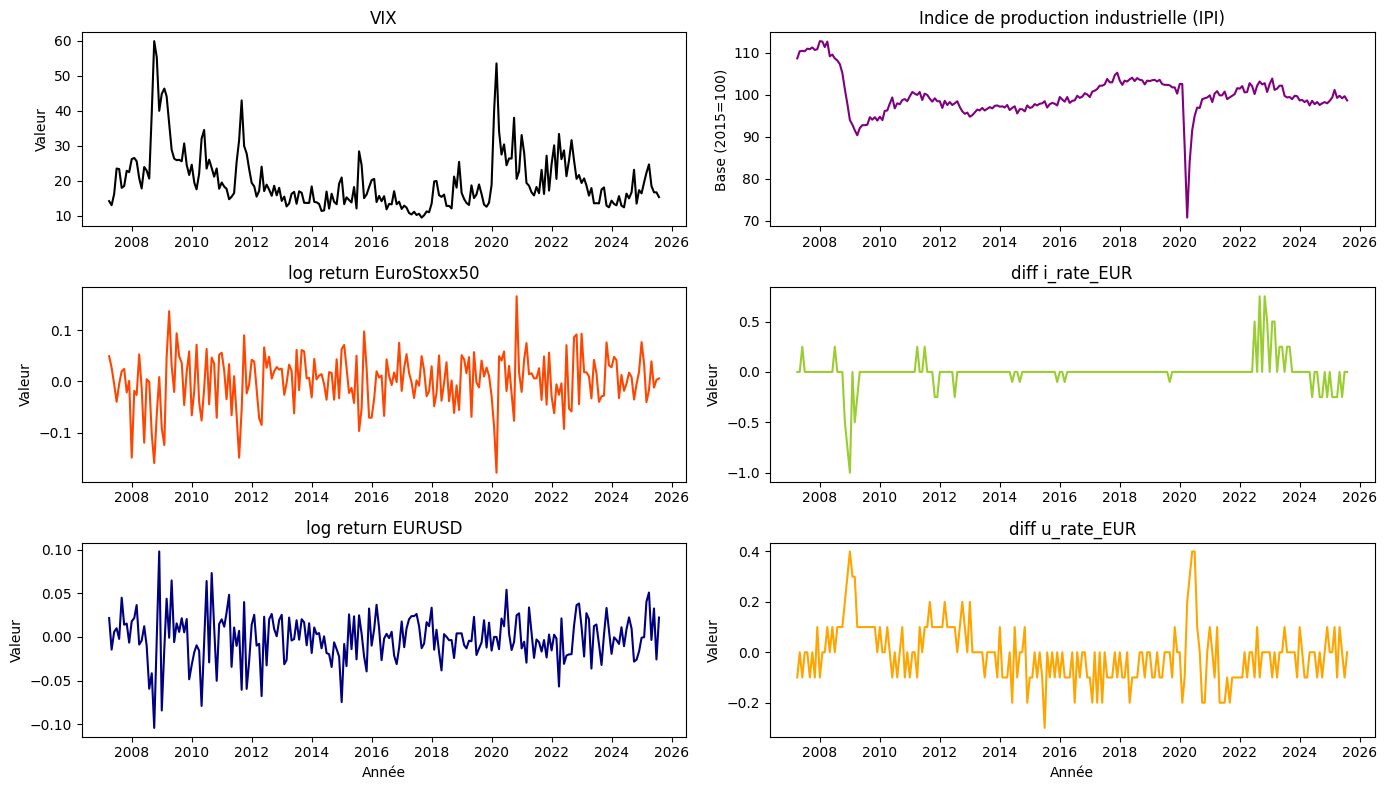

In [98]:
fig, axs = plt.subplots(3, 2, figsize=(14, 8))

axs[0][0].plot(df_final['VIX'], color='black')
axs[0][0].set_title('VIX')
axs[0][0].set_ylabel('Valeur')

axs[1][0].plot(df_final['log_return_EuroStoxx50'], color='orangered')
axs[1][0].set_title('log return EuroStoxx50')
axs[1][0].set_ylabel('Valeur')

axs[2][0].plot(df_final['log_return_EURUSD'], color='navy')
axs[2][0].set_title('log return EURUSD')
axs[2][0].set_ylabel('Valeur')
axs[2][0].set_xlabel('Année')

axs[0][1].plot(df_final['IPI'], color='purple')
axs[0][1].set_title('Indice de production industrielle (IPI)')
axs[0][1].set_ylabel('Base (2015=100)')

axs[1][1].plot(df_final['diff_i_rate_EUR'], color='yellowgreen')
axs[1][1].set_title('diff i_rate_EUR')
axs[1][1].set_ylabel('Valeur')

axs[2][1].plot(df_final['diff_u_rate_EUR'], color='orange')
axs[2][1].set_title("diff u_rate_EUR")
axs[2][1].set_ylabel('Valeur')
axs[2][1].set_xlabel('Année')

plt.tight_layout()
plt.show()

---

## 4. Tests usuels

### 4.1 Test de Portmanteau

### 4.2 Breusch-Godfrey

---

## 5.  VAR

### 5.1 Sélection du nombre optimal de retards (lags) pour chaque modèle VAR

Le nombre optimal de retards (lags) est déterminé à l’aide des critères d’information classiques, notamment les critères AIC et BIC, de façon à capturer les dynamiques temporelles pertinentes sans surparamétrer le modèle.

Le but est de trouver un compromis entre :

- un modèle trop court → mauvaise dynamique (biais d’omission)

- un modèle trop long → perte de degrés de liberté (sur-ajustement)

In [77]:
# lags optimaux selon AIC
model = VAR(df_final)
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.81      -14.71   3.709e-07      -14.77
1       -17.85     -17.18*   1.762e-08      -17.58
2       -18.09      -16.84  1.393e-08*     -17.59*
3      -18.09*      -16.27   1.393e-08      -17.36
4       -18.03      -15.63   1.495e-08      -17.06
5       -18.03      -15.06   1.490e-08      -16.83
6       -18.01      -14.46   1.544e-08      -16.57
7       -18.01      -13.88   1.567e-08      -16.34
8       -17.90      -13.20   1.768e-08      -16.00
9       -17.72      -12.44   2.173e-08      -15.59
10      -17.54      -11.68   2.688e-08      -15.17
11      -17.43      -11.00   3.094e-08      -14.83
12      -17.48      -10.47   3.093e-08      -14.64
--------------------------------------------------


## Impulse Response Function (IRF)

## Causalité de Granger